In [34]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run lib/preamble.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Models

In [2]:
def zero_r():
    def train_fn(model, train, *args, platform=None, **kwargs):
        """ train a model """
        if platform == "amd":
            model["zero_r"] = 0
        elif platform == "nvidia":
            model["zero_r"] = 1

    def test_fn(model, test, seed, *args, **kwargs):
        """ make predictions for test data """
        return [model["zero_r"]] * len(test["y"])

    def save_fn(outpath, model):
        """ save a trained model """
        with open(outpath, "wb") as outfile:
            pickle.dump(model, outfile)
    
    def load_fn(inpath):
        """ load a trained model """
        with open(inpath, "rb") as infile:
            model = pickle.load(infile)
        return model

    return {
        "name": "zero_r",
        "train_fn": train_fn,
        "test_fn": test_fn,
        "save_fn": save_fn,
        "load_fn": load_fn
    }

In [3]:
def cgo13():
    def create_model(seed=204, **kwargs):
        """ instantiate a model """ 
        return DecisionTreeClassifier(random_state=seed, splitter="best", criterion="entropy")

    def train_fn(model, train, validation, *args, **kwargs):
        """ train a model """
        np.random.seed(seed)
        model.fit(train["x_4"], train["y"])
        return {}

    def test_fn(model, test, seed, *args, **kwargs):
        """ make predictions for test data """
        np.random.seed(seed)
        return model.predict(test["x_4"])
    
    def save_fn(outpath, model):
        """ save a trained model """
        with open(outpath, "wb") as outfile:
            pickle.dump(model, outfile)
    
    def load_fn(inpath):
        """ load a trained model """
        with open(inpath, "rb") as infile:
            model = pickle.load(infile)
        return model
        
    return {
        "name": "cgo13",
        "create_model": create_model,
        "train_fn": train_fn,
        "test_fn": test_fn,
        "save_fn": save_fn,
        "load_fn": load_fn
    }

In [4]:
def harry():
    BATCH_SIZE = 64
    EMBEDDING_VECTOR_LEN = 64
    
    def create_model(*args, data_desc=None, **kwargs):
        """ instantiate a model """ 
        atomizer = data_desc["atomizer"]
        seq_length = data_desc["seq_length"]
        vocab_size = atomizer.vocab_size + 1

        dyn_inputs = Input(shape=(2,), name="data_in")
        left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

        seq_inputs = Input(shape=(seq_length,), dtype="int32", name="code_in")
        right = Embedding(output_dim=EMBEDDING_VECTOR_LEN, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
        right = LSTM(16, consume_less="mem")(right)
        right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

        aux_out = Dense(2, activation="sigmoid", name="aux_out")(right)

        x = merge([left, right], mode="concat")
        x = Dense(18, activation="relu")(x)
        out = Dense(2, activation="sigmoid", name="out")(x)

        model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])
        model.compile(optimizer="adam",
                      loss={"out": "categorical_crossentropy", "aux_out": "categorical_crossentropy"},
                      loss_weights={"out": 1., "aux_out": .2},
                      metrics=['accuracy'])
        return model
    
    def train_fn(model, train, *args, validation=None, **kwargs):
        """ train a model """
        model.fit({"data_in": train["x_2"], "code_in": train["x_seq"]},
                  {"out": train["y_2"], "aux_out": train["y_2"]},
                  nb_epoch=1,
                  batch_size=BATCH_SIZE,
                  validation_data=({"data_in": validation["x_2"], "code_in": validation["x_seq"]},
                                   {"out": validation["y_2"], "aux_out": validation["y_2"]}),
                  verbose=1,
                  shuffle=True)

    def test_fn(model, test, seed, *args, **kwargs):
        """ make predictions for test data """
        predictions = np.array(model.predict({"data_in": test["x_2"], "code_in": test["x_seq"]},
                                             batch_size=BATCH_SIZE, verbose=0))
        clipped = [np.argmax(x) for x in predictions[0]]
        return clipped

    def save_fn(outpath, model):
        """ save a trained model """
        model.save(outpath)
    
    def load_fn(inpath):
        """ load a trained model """
        return load_model(inpath)

    return {
        "name": "harry",
        "create_model": create_model,
        "train_fn": train_fn,
        "test_fn": test_fn,
        "save_fn": save_fn,
        "load_fn": load_fn
    }

In [5]:
def sally():
    BATCH_SIZE = 64
    EMBEDDING_VECTOR_LEN = 64
    
    def create_model(*args, data_desc=None, **kwargs):
        """ instantiate a model """ 
        atomizer = data_desc["atomizer"]
        seq_length = data_desc["seq_length"]
        vocab_size = atomizer.vocab_size + 1

        dyn_inputs = Input(shape=(2,), name="data_in")
        left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

        seq_inputs = Input(shape=(seq_length,), dtype="int32", name="code_in")
        right = Embedding(output_dim=EMBEDDING_VECTOR_LEN, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
        right = LSTM(32, consume_less="mem", return_sequences=True)(right)
        right = LSTM(32, consume_less="mem")(right)
        right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

        aux_out = Dense(2, activation="sigmoid", name="aux_out")(right)

        x = merge([left, right], mode="concat")
        x = Dense(34, activation="relu")(x)
        x = Dense(34, activation="relu")(x)
        out = Dense(2, activation="sigmoid", name="out")(x)

        model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])
        model.compile(optimizer="adam",
                      loss={"out": "categorical_crossentropy", "aux_out": "categorical_crossentropy"},
                      loss_weights={"out": 1., "aux_out": .2},
                      metrics=['accuracy'])
        return model
    
    def train_fn(model, train, *args, validation=None, **kwargs):
        """ train a model """
        model.fit({"data_in": train["x_2"], "code_in": train["x_seq"]},
                  {"out": train["y_2"], "aux_out": train["y_2"]},
                  nb_epoch=1,
                  batch_size=BATCH_SIZE,
                  validation_data=({"data_in": validation["x_2"], "code_in": validation["x_seq"]},
                                   {"out": validation["y_2"], "aux_out": validation["y_2"]}),
                  verbose=1,
                  shuffle=True)

    def test_fn(model, test, seed, *args, **kwargs):
        """ make predictions for test data """
        predictions = np.array(model.predict({"data_in": test["x_2"], "code_in": test["x_seq"]},
                                             batch_size=BATCH_SIZE, verbose=0))
        clipped = [np.argmax(x) for x in predictions[0]]
        return clipped

    def save_fn(outpath, model):
        """ save a trained model """
        model.save(outpath)
    
    def load_fn(inpath):
        """ load a trained model """
        return load_model(inpath)

    return {
        "name": "sally",
        "create_model": create_model,
        "train_fn": train_fn,
        "test_fn": test_fn,
        "save_fn": save_fn,
        "load_fn": load_fn
    }

# Evaluate

In [6]:
from itertools import product

def source2str(s):
    if s == "B":
        return "Benchmarks"
    elif s == "S":
        return "CLgen"
    elif s == "BS":
        return "w. CLgen"
    else:
        raise Exception
        
def model2str(m):
    if m == "zero_r":
        return "Zero-R"
    elif m == "cgo13":
        return "Grewe et al."
    else:
        return m.title()

### Character Atomizer

In [87]:
# %%capture
split = (.6, .2, .2)

# ranges
models = ["zero_r", "cgo13", "harry", "sally"]
platforms = ["amd", "nvidia"]
atomizers = ["CharacterAtomizer", "GreedyAtomizer"]
sources = ["B"]
seeds = list(range(204, 214))

data_in = []
for row in product(models, platforms, atomizers, sources, seeds):
    model, platform, atomizer, source, seed = row

    m = globals().get(model)()
    model_path = get_model_path(m, platform, source, split=split, atomizer=atomizer_txt, seed=seed)
    if fs.exists(model_path):
        r = load_and_test(m, platform, source, split=split, atomizer=atomizer, seed=seed)
        r["acc_perc"] = r["accuracy"] * 100
        r["model"] = model
        r["model_name"] = model.upper()
        r["platform"] = platform
        r["platform_name"] = platform.upper()
        r["oracle_perc"] = r["speedup_avg"] * 100
        r["source"] = source
        r["source_name"] = source2str(source)
        r["split"] = split
        r["atomizer"] = atomizer_txt
        data_in.append(r)
    else:
        print("warning: no model file", model_path, file=sys.stderr)

data = pd.DataFrame(data_in)

model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-204.model
[[79  0]
 [66  0]]
result saved to models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-204.result
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-205.model
[[73  0]
 [55  0]]
result saved to models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-205.result
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-206.model
[[77  0]
 [54  0]]
result saved to models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-206.result
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-207.model
[[79  0]
 [50  0]]
result saved to models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-207.result
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-208.model
[[86  0]
 [53  0]]
result saved to models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-208.result
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-209.model
[[81  0]
 [64  0]]
result save

model loaded from models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-204.model
[[ 0 56]
 [ 0 89]]
result saved to models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-204.result
model loaded from models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-205.model
[[ 0 60]
 [ 0 68]]
result saved to models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-205.result
model loaded from models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-206.model
[[ 0 58]
 [ 0 73]]
result saved to models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-206.result
model loaded from models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-207.model
[[ 0 53]
 [ 0 76]]
result saved to models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-207.result
model loaded from models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-208.model
[[ 0 57]
 [ 0 82]]
result saved to models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-208.result
model loaded from models/zero_r/nvidia-B-60:20:20-CharacterAtomizer:1024-209.mod

model loaded from models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-204.model
[[70  9]
 [17 49]]
result saved to models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-204.result
model loaded from models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-205.model
[[56 17]
 [13 42]]
result saved to models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-205.result
model loaded from models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-206.model
[[71  6]
 [16 38]]
result saved to models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-206.result
model loaded from models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-207.model
[[69 10]
 [11 39]]
result saved to models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-207.result
model loaded from models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-208.model
[[67 19]
 [13 40]]
result saved to models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-208.result
model loaded from models/cgo13/amd-B-60:20:20-CharacterAtomizer:1024-209.model
[[71 10]
 [17 47]]
result saved to models

model loaded from models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-204.model
[[48  8]
 [16 73]]
result saved to models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-204.result
model loaded from models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-205.model
[[49 11]
 [13 55]]
result saved to models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-205.result
model loaded from models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-206.model
[[43 15]
 [18 55]]
result saved to models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-206.result
model loaded from models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-207.model
[[41 12]
 [ 7 69]]
result saved to models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-207.result
model loaded from models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-208.model
[[46 11]
 [13 69]]
result saved to models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-208.result
model loaded from models/cgo13/nvidia-B-60:20:20-CharacterAtomizer:1024-209.model
[[44 14]

model loaded from models/harry/amd-B-60:20:20-CharacterAtomizer:1024-204.model
[[69 10]
 [19 47]]
result saved to models/harry/amd-B-60:20:20-CharacterAtomizer:1024-204.result
model loaded from models/harry/amd-B-60:20:20-CharacterAtomizer:1024-205.model
[[60 13]
 [18 37]]
result saved to models/harry/amd-B-60:20:20-CharacterAtomizer:1024-205.result
model loaded from models/harry/amd-B-60:20:20-CharacterAtomizer:1024-206.model
[[52 25]
 [ 9 45]]
result saved to models/harry/amd-B-60:20:20-CharacterAtomizer:1024-206.result
model loaded from models/harry/amd-B-60:20:20-CharacterAtomizer:1024-207.model
[[54 25]
 [10 40]]
result saved to models/harry/amd-B-60:20:20-CharacterAtomizer:1024-207.result
model loaded from models/harry/amd-B-60:20:20-CharacterAtomizer:1024-208.model
[[79  7]
 [34 19]]
result saved to models/harry/amd-B-60:20:20-CharacterAtomizer:1024-208.result
model loaded from models/harry/amd-B-60:20:20-CharacterAtomizer:1024-209.model
[[62 19]
 [10 54]]
result saved to models

model loaded from models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-204.model
[[30 26]
 [13 76]]
result saved to models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-204.result
model loaded from models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-205.model
[[48 12]
 [16 52]]
result saved to models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-205.result
model loaded from models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-206.model
[[41 17]
 [16 57]]
result saved to models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-206.result
model loaded from models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-207.model
[[37 16]
 [18 58]]
result saved to models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-207.result
model loaded from models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-208.model
[[47 10]
 [18 64]]
result saved to models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-208.result
model loaded from models/sally/nvidia-B-60:20:20-CharacterAtomizer:1024-209.model
[[40 18]

In [301]:
%run lib/preamble.py
models = ["zero_r", "cgo13"]#, "harry", "sally"]
platforms = ["amd", "nvidia"]
sources = ["B"]
atomizers = ["CharacterAtomizer", "GreedyAtomizer"]
seeds = list(range(204, 214))

data = None

for model, platform, source, atomizer, seed in product(models, platforms, sources, atomizers, seeds):
    result = load_and_test(globals().get(model)(), platform, source, 
                           split=split, atomizer=atomizer, maxlen=1024, seed=204)
    if not result:
        continue
    
    frame = result["dataframe"]
    frame["correct"] = result["correct"]
    frame["acc"] = result["correct"] * 100
    frame["p_speedup"] = result["speedups"]
    frame["p_speedup_perc"] = frame["p_speedup"] * 100
    frame["model"] = [model] * len(frame)
    frame["platform"] = [platform] * len(frame)
    frame["atomizer"] = [atomizer] * len(frame)

    if d is None:
        data = frame
    else:
        data = pd.concat((data, frame))

foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo
foo


In [302]:
data

,F1:transfer/(comp+mem),F2:coalesced/mem,F3:(localmem/mem)*avgws,F4:comp/mem,atomic,benchmark,coalesced,comp,dataset,localmem,...,synthetic,transfer,wgsize,correct,acc,p_speedup,p_speedup_perc,model,platform,atomizer
0,3.076783e+05,0.333,0.000000,18.300,0,parboil-0.2-sad-mb_sad_calc,1,55,default,0,...,0,17845344,61,False,0,0.212029,21.202893,zero_r,amd,CharacterAtomizer
1,1.116878e+04,5.600,0.000000,13.400,0,npb-3.3-SP-initialize3,28,67,S,0,...,0,804152,60,True,100,1.000000,100.000000,zero_r,amd,CharacterAtomizer
2,2.157508e+03,25.900,0.000000,92.100,0,npb-3.3-BT-y_solve,233,829,S,0,...,0,1807992,60,True,100,1.000000,100.000000,zero_r,amd,CharacterAtomizer
3,8.694247e+04,2.200,0.000000,13.600,0,npb-3.3-LU-rhs,11,68,W,0,...,0,6346800,33,True,100,1.000000,100.000000,zero_r,amd,CharacterAtomizer
4,2.437447e+04,25.800,0.000000,92.000,0,npb-3.3-SP-z_solve,232,828,W,0,...,0,20401432,34,True,100,1.000000,100.000000,zero_r,amd,CharacterAtomizer
5,9.967740e+05,5.000,0.000000,15.000,0,npb-3.3-BT-y_solve2,5,15,W,0,...,0,15948384,44,True,100,1.000000,100.000000,zero_r,amd,CharacterAtomizer
6,1.318499e+06,22.400,0.000000,68.000,0,npb-3.3-SP-exact_rhs3,112,340,B,0,...,0,454882072,32,True,100,1.000000,100.000000,zero_r,amd,CharacterAtomizer
7,9.546236e+06,1.000,0.000000,15.700,0,npb-3.3-MG-kernel_zran3_1,3,47,A,0,...,0,477311792,4,False,0,0.739393,73.939313,zero_r,amd,CharacterAtomizer
8,3.698244e+06,5.710,0.000000,16.600,0,npb-3.3-SP-initialize2,40,116,B,0,...,0,454884072,32,False,0,0.089652,8.965207,zero_r,amd,CharacterAtomizer
9,4.252902e+04,67.700,0.000000,124.000,0,npb-3.3-BT-x_solve3,203,372,W,0,...,0,15948384,44,True,100,1.000000,100.000000,zero_r,amd,CharacterAtomizer


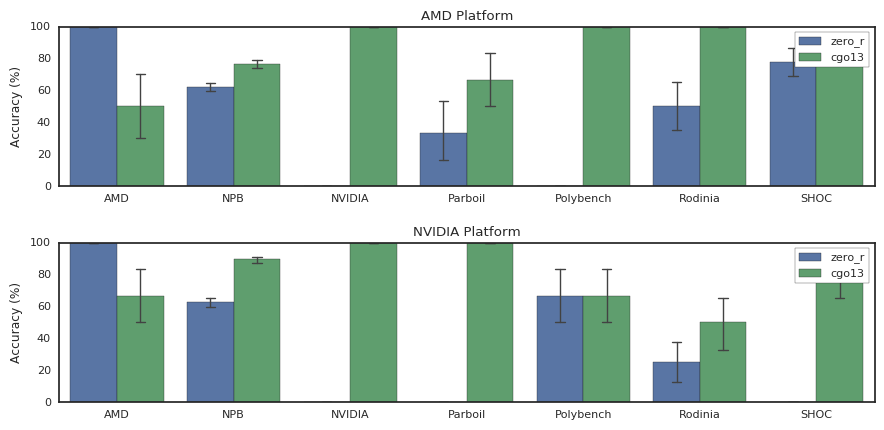

In [306]:
order = ["AMD", "NPB", "NVIDIA", "Parboil", "Polybench", "Rodinia", "SHOC"]
for i, platform in enumerate(["amd", "nvidia"]):
    plt.subplot(2, 1, i + 1)
    ax = sns.barplot(x="source", y="acc", hue="model", order=order,
                     data=data[(data["platform"] == platform) & ((data["model"] == "zero_r") | (data["model"] == "cgo13") | (data["model"] == "harry")) & (data["atomizer"] == "CharacterAtomizer")],
                     ci=95, errwidth=1, capsize=.08)

    plt.ylim((0, 100))
    plt.title("{platform} Platform".format(platform=platform.upper()))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("")
    
    # legent
    plt.legend(loc='upper right')
    ax.get_legend().set_title("")  # no legend title
    ax.get_legend().draw_frame(True)

viz.finalise(figsize=(9,4.5))

### Performance (% optimal)

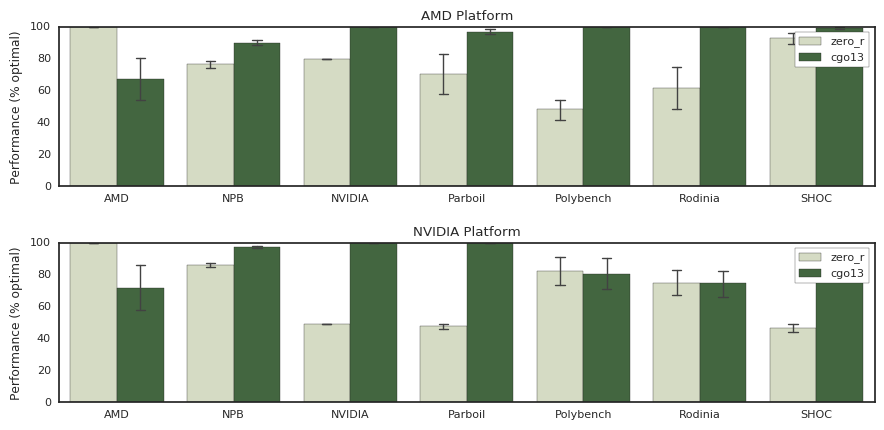

In [328]:
for i, platform in enumerate(["amd", "nvidia"]):
    plt.subplot(2, 1, i + 1)
    ax = sns.barplot(x="source", y="p_speedup_perc", hue="model", order=order, palette=model_palette,
                     data=data[(data["platform"] == platform) & ((data["model"] == "zero_r") | (data["model"] == "cgo13") | (data["model"] == "harry")) & (data["atomizer"] == "CharacterAtomizer")],
                     ci=95, errwidth=1, capsize=.08)

    plt.ylim((0, 100))
    plt.title("{platform} Platform".format(platform=platform.upper()))
    plt.ylabel("Performance (% optimal)")
    plt.xlabel("")
    
    # legent
    plt.legend(loc='upper right')
    ax.get_legend().set_title("")  # no legend title
    ax.get_legend().draw_frame(True)

viz.finalise(figsize=(9,4.5))

### Data splits

num instances 680 (0 synthetic, 680 benchmarks)
unique kernels 247
vocab size 84
pad val 84
padded seq length 1024


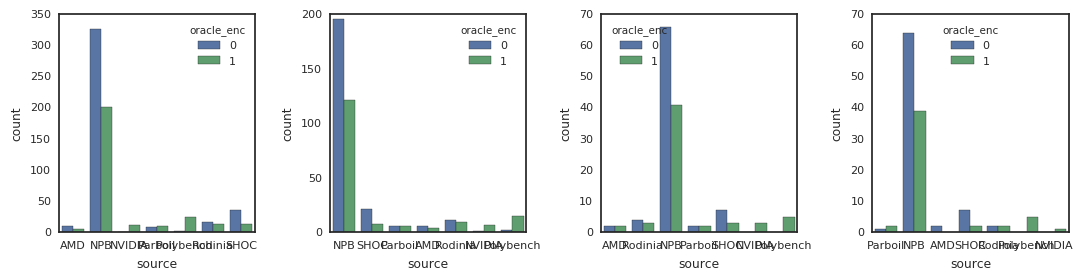

In [299]:
%run lib/preamble.py
d = load_dataframe("amd", "B", 1024, atomizer=CharacterAtomizer)
frame = d["dataframe"]

x = get_train_validation_test_splits(frame, seed=204)

plt.subplot(1, 4, 1)
sns.countplot(x="source", hue="oracle_enc", data=frame)
plt.subplot(1, 4, 2)
sns.countplot(x="source", hue="oracle_enc", data=x[0])
plt.subplot(1, 4, 3)
sns.countplot(x="source", hue="oracle_enc", data=x[1])
plt.subplot(1, 4, 4)
sns.countplot(x="source", hue="oracle_enc", data=x[2])
viz.finalise(figsize=(11,3))

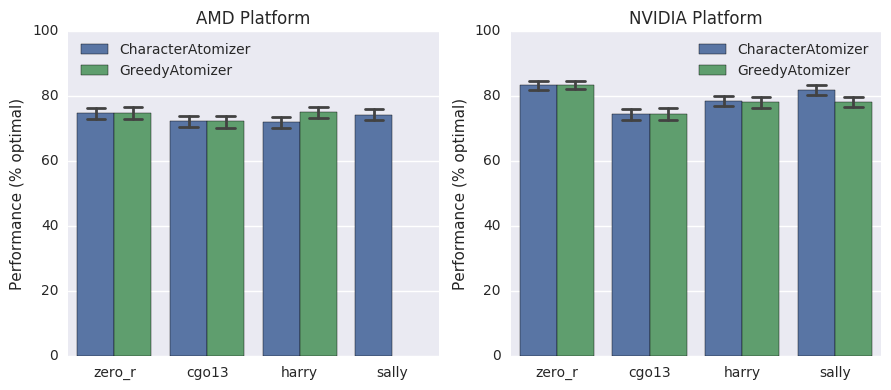

In [154]:
for i, platform in enumerate(["amd", "nvidia"]):
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(x="model", y="p_speedup_perc", hue="atomizer",
                     data=data[data["platform"] == platform],
                     ci=95, errwidth=2, capsize=.2)
    ax.get_legend().set_title("")  # no legend title
    plt.ylim((0, 100))
    plt.title("{platform} Platform".format(platform=platform.upper()))
    plt.ylabel("Performance (% optimal)")
    plt.xlabel("")

viz.finalise(figsize=(9,4))

### Greedy Atomizer

In [ ]:
# %%capture
seeds = list(range(204, 214))
split = (.6, .2, .2)
source = "B"

for model, platform, seed in product(["zero_r", "cgo13", "harry", "sally"], ["amd", "nvidia"], seeds):
    m = globals().get(model)()
    model_path = get_model_path(m, platform, source, split=split, atomizer="GreedyAtomizer", seed=seed)
    if fs.exists(model_path):
        r = load_and_test(m, platform, source, split=split, atomizer=GreedyAtomizer, seed=seed)
        r["acc_perc"] = r["accuracy"] * 100
        r["model"] = model
        r["model_name"] = model.upper()
        r["platform"] = platform
        r["platform_name"] = platform.upper()
        r["oracle_perc"] = r["speedup_avg"] * 100
        r["source"] = source
        r["source_name"] = source2str(source)
        r["split"] = split
        r["vocab"] = "token"
        data_in.append(r)
    else:
        print("warning: no model file", model_path, file=sys.stderr)

data = pd.DataFrame(data_in)

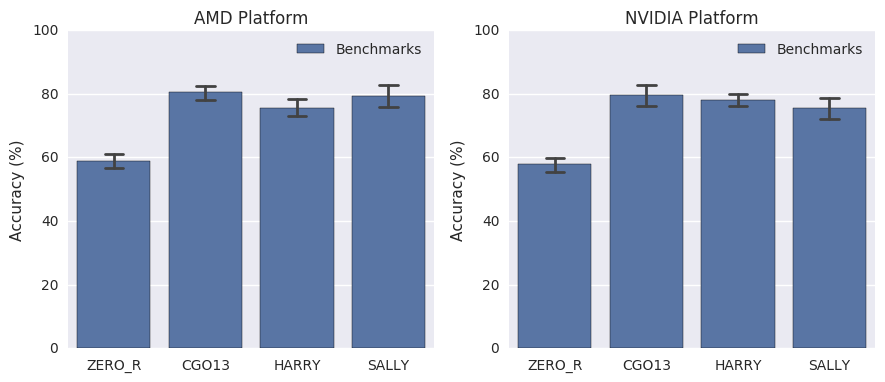

In [12]:
for i, platform in enumerate(["AMD", "NVIDIA"]):
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(x="model_name", y="acc_perc", hue="source_name",
                    data=data[data["platform_name"] == platform],
                    ci=99, errwidth=2, capsize=.2)
    ax.get_legend().set_title("")  # no legend title
    plt.ylim((0, 100))
    plt.title("{platform} Platform".format(platform=platform.upper()))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("")

viz.finalise(figsize=(9,4))

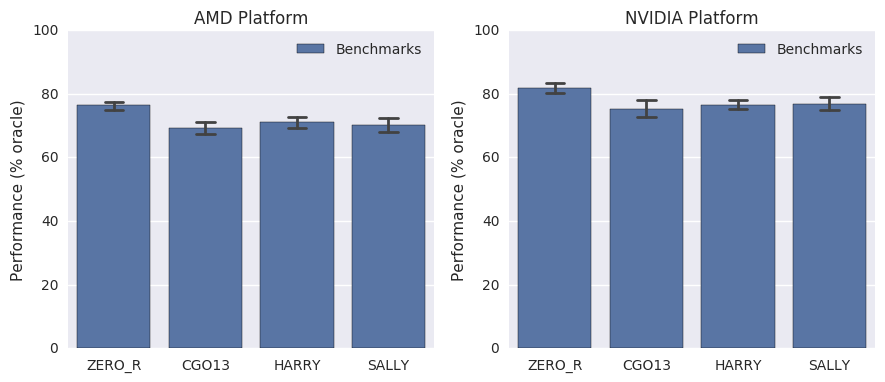

In [13]:
for i, platform in enumerate(["AMD", "NVIDIA"]):
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(x="model_name", y="oracle_perc", hue="source_name",
                     data=data[data["platform_name"] == platform],
                     ci=99, errwidth=2, capsize=.2)
    ax.get_legend().set_title("")  # no legend title
    plt.ylim((0, 100))
    plt.title("{platform} Platform".format(platform=platform.upper()))
    plt.ylabel("Performance (% oracle)")
    plt.xlabel("")

viz.finalise(figsize=(9,4))